In [1]:
import pandas as pd
import itertools
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [6]:
data = pd.read_csv('../data\circuit_flight\dense_flights_data.csv')
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK',
       'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED',
       'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'ORIGIN_AIRPORT_IATA', 'DESTINATION_AIRPORT_IATA',
       'Date', 'SD', 'DT', 'WF', 'WN', 'SA', 'AT', 'FLIGHT_ID'],
      dtype='object')

In [7]:
class pipline:
    def __init__(self,flights,is_iqr,is_boxcox,train_ratio=0.8):
        self.flights = flights
        self.is_iqr = is_iqr,
        self.is_boxcox = is_boxcox 
        self.train_ratio = train_ratio

    def IQR(self,y):
        Q3 = y.quantile(0.75)
        Q1 = y.quantile(0.25)
        IQR = Q3-Q1
        lower_bound = Q1 - IQR*1.5
        upper_bound = Q3 + IQR*1.5

        y[(y > upper_bound).values | (y<lower_bound).values] = np.nan
        y = y.interpolate(method='linear') 
        return y
    
    def box_cox(self,y):
        y_min = np.min(y)-0.1
        y_box, lbd = boxcox(y.values.ravel()-y_min.ravel())  
        self.lbd = lbd
        self.y_min = y_min
        return y_box
    
    def fit(self,start_p,start_q,max_p,max_q):
        y_raw = self.flights.iloc[:int(np.floor(self.flights.shape[0]*self.train_ratio)),:].loc[:,['ARRIVAL_DELAY','SD']].set_index('SD').interpolate(method='linear')
        y_test = self.flights.iloc[int(np.floor(self.flights.shape[0]*self.train_ratio)):,:].loc[:,['ARRIVAL_DELAY','SD']].set_index('SD').interpolate(method='linear')

        if self.is_iqr:
            y_iqr = self.IQR(y_raw)
        else:
            y_iqr = y_raw

        if self.is_boxcox:
            y_box = self.box_cox(y_iqr)
        else:
            y_box = y_iqr

        y_box = pd.Series(y_box).dropna()

        model = pm.auto_arima(y_box, seasonal=False, trace=False,start_p=start_p,start_q=start_q,max_p=max_p,max_q=max_q)
        self.model = model

        y_pred = []
        for i in range(len(y_test)):
            forecast = model.predict_in_sample(X=y_box, start=len(y_box)-len(y_test)+i, end=len(y_box)-len(y_test)+i)
            y_pred.append(forecast.iloc[0])

        y_pred = np.array(y_pred)

        if self.is_boxcox:
            # 对预测值进行box-cox逆变换
            y_pred = inv_boxcox(y_pred, self.lbd) + self.y_min.ravel()

        self.y_test = y_test
        self.y_pred = y_pred

    def metrics(self):
        rmse = np.sqrt(mean_squared_error(self.y_test, self.y_pred))
        print(f"RMSE: {rmse:.3f}")

        # 计算MAE
        mae = mean_absolute_error(self.y_test, self.y_pred)
        print(f"MAE: {mae:.3f}")

        # 计算MAPE
        mape = mean_absolute_percentage_error(self.y_test, self.y_pred)
        print(f"MAPE: {mape:.3%}")

    def summary(self):
        print(self.model.summary())

    def plot(self):
        # 绘制实际值和预测值
        plt.figure(figsize=(12, 6))
        plt.plot(self.y_test.values, label='Actual')
        plt.plot(self.y_pred, label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Actual vs. Predicted Values')
        plt.legend()
        plt.show()


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1452
Model:               SARIMAX(4, 0, 3)   Log Likelihood               -2793.857
Date:                Tue, 07 May 2024   AIC                           5605.714
Time:                        23:11:34   BIC                           5653.240
Sample:                             0   HQIC                          5623.448
                               - 1452                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.9501      3.948      1.000      0.317      -3.788      11.688
ar.L1         -0.2237      0.252     -0.887      0.375      -0.718       0.270
ar.L2          0.7464      0.259      2.878      0.0

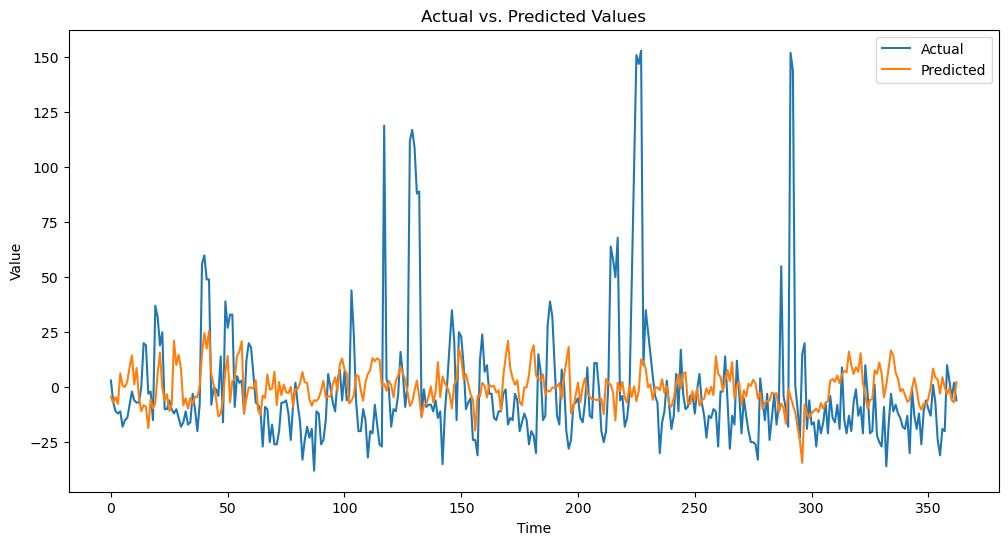

RMSE: 30.175
MAE: 18.910
MAPE: 20282762885437932.000%


In [11]:
P = pipline(data.loc[data['FLIGHT_ID'] == 'AS64'],is_iqr=True,is_boxcox=True,train_ratio=0.8)
P.fit()
P.summary()
P.plot()
P.metrics()